In [4]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import subprocess as sp
from PIL import Image

from datetime import datetime

from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
DEVICE = "cuda"

In [5]:
##########################
### LeNet-5 구조 정의 - default (배치 정규화)
### 활성화 함수: tanh, 출력층 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        # Sequential: layer을 순서대로 적용
        self.feature_extractor = nn.Sequential(          
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [6]:
# MNIST 데이터셋 로드

def load_data(validation_split=0.2, batch_size=32):
    transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

    train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=validation_split, random_state=42, shuffle=True)
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, val_loader

train_loader, val_loader = load_data(batch_size=32)

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for X, y_true in train_loader:
        optimizer.zero_grad()
        X = X.to(device)
        y_true = y_true.to(device)
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for X, y_true in val_loader:
            X = X.to(device)
            y_true = y_true.to(device)
            y_hat, _ = model(X)
            loss = criterion(y_hat, y_true)
            running_loss += loss.item() * X.size(0)
    epoch_loss = running_loss / len(val_loader.dataset)
    return model, epoch_loss

def get_accuracy(model, data_loader, device):
    correct_pred = 0
    n = 0
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X.to(device)
            y_true = y_true.to(device)
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)
            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()
    return correct_pred.float() / n


In [8]:
import random

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def hyperparameter_optimization(trials=10):
    best_val_acc = 0
    best_params = None
    results = []

    for _ in range(trials):
        lr = 10 ** np.random.uniform(-4, -2)
        batch_size = random.choice([16, 32, 64, 128])

        train_loader, val_loader = load_data(batch_size=batch_size)
        model = LeNet5(10).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(10):  # Modify the number of epochs as needed
            model, optimizer, train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
            model, val_loss = validate_epoch(model, val_loader, criterion, DEVICE)

        val_acc = get_accuracy(model, val_loader, DEVICE).item()
        results.append((lr, batch_size, val_acc))

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = (lr, batch_size)

    print(f"Best params: Learning Rate={best_params[0]}, Batch Size={best_params[1]}, Validation Accuracy={best_val_acc}")

    return results

# Run the hyperparameter optimization
results = hyperparameter_optimization(trials=10)


Best params: Learning Rate=0.001411275245141201, Batch Size=32, Validation Accuracy=0.9900833368301392


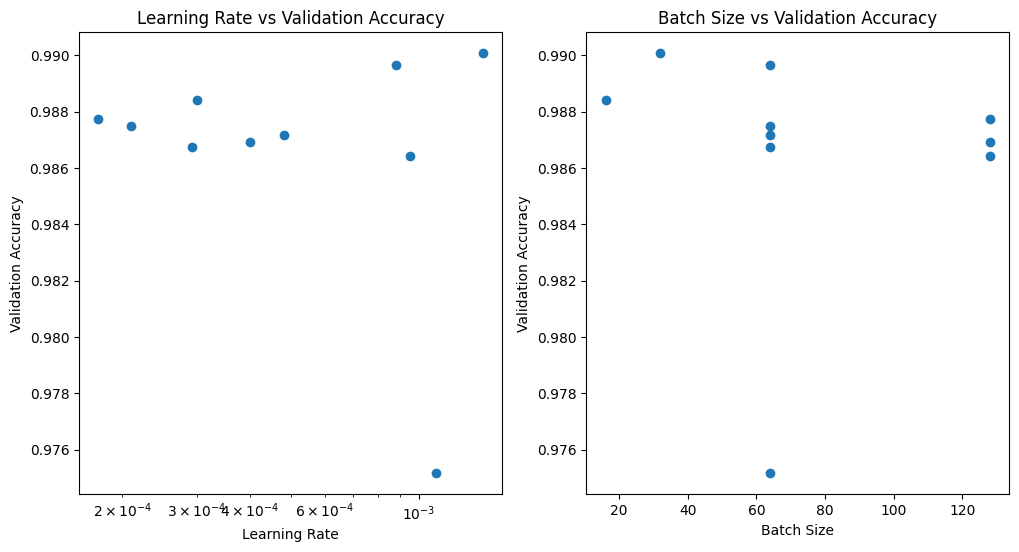

In [9]:
def plot_results(results):
    lrs, batch_sizes, val_accs = zip(*results)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(lrs, val_accs)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Validation Accuracy')
    plt.title('Learning Rate vs Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.scatter(batch_sizes, val_accs)
    plt.xlabel('Batch Size')
    plt.ylabel('Validation Accuracy')
    plt.title('Batch Size vs Validation Accuracy')

    plt.show()

# Plot the results
plot_results(results)
